# Feature and more

## Justification rétrospective de certains choix

In [12]:

import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 🌡️ Comprendre les unités : kBtu et émissions de CO₂e

### 🔋 1. Qu’est-ce que le `SiteEnergyUse(kBtu)` ?

La colonne `SiteEnergyUse(kBtu)` indique la **consommation totale d'énergie annuelle d’un bâtiment**, exprimée en **kBtu**, soit :

- **1 kBtu** = 1 000 **British thermal units**
- **1 Btu** ≈ 1 055 joules
- Donc **1 kBtu ≈ 0.293 kWh**

> 👉 Un bâtiment qui consomme 14 172 606 kBtu/an utilise environ **4,15 millions de kWh/an**,  
> soit **autant que 346 maisons individuelles** (moyenne de 12 000 kWh/an par maison).

### 🌪️ 2. Et `SiteEnergyUseWN(kBtu)` ? Quelle différence ?

`SiteEnergyUseWN(kBtu)` signifie **"Site Energy Use - Weather Normalized"**, c’est-à-dire :

> ⚠️ **Consommation énergétique corrigée des variations climatiques**

- Cela représente **ce qu’aurait été la consommation du bâtiment dans une année météo "standardisée"**
- Elle permet de **neutraliser l’effet des hivers plus froids ou des étés plus chauds**
- C’est une **valeur modélisée** utile pour comparer équitablement plusieurs bâtiments d’une même région

> 📌 Exemple :
> - `SiteEnergyUse(kBtu)` = 15 000 000 → année réellement froide
> - `SiteEnergyUseWN(kBtu)` = 12 800 000 → consommation estimée sans ce froid excessif

### 🧪 Dans quels cas cette variable est-elle utile ?

Cette valeur **modélisée** est précieuse dans certains contextes :

| Cas d’usage                                    | Pourquoi l’utiliser ?                                      |
|------------------------------------------------|-------------------------------------------------------------|
| 📊 Benchmark énergétique entre bâtiments       | Supprime les biais dus aux différences climatiques locales |
| 🔁 Suivi d’un bâtiment d’année en année        | Neutralise les hivers anormaux ou étés extrêmes            |
| 🏛️ Politiques publiques / subventions         | Permet une évaluation équitable de l'efficacité réelle     |
| 📈 Études structurelles sur la performance     | Permet de comparer "structurellement" les bâtiments        |

---

### ❌ Pourquoi **ne PAS** l’utiliser ici ?

Notre objectif est de **prédire la consommation d’énergie réelle** (`SiteEnergyUse(kBtu)`) d’un bâtiment.  
Autrement dit, **ce que le compteur mesurera** (et ce qui sera facturé).

Utiliser la version "normalisée climat" serait problématique pour 3 raisons :

1. **Non observable** : on ne connaît pas `SiteEnergyUseWN(kBtu)` avant d’avoir mesuré l’année.
2. **Inclut déjà un modèle** : elle est le résultat d’un ajustement statistique → risque de **data leakage**.
3. **Pas fidèle à la réalité terrain** : notre modèle vise une prédiction "terrain", pas une estimation abstraite.

---

### ✅ En résumé

| Variable               | À utiliser ? | Raisonnement                                  |
|------------------------|--------------|-----------------------------------------------|
| `SiteEnergyUse(kBtu)`  | ✅ OUI       | Cible réelle, mesurée, conforme au terrain    |
| `SiteEnergyUseWN(kBtu)`| ❌ NON       | Valeur modélisée, non disponible en amont     |


### 🌍 3. Qu’est-ce que le `TotalGHGEmissions` ?

La colonne `TotalGHGEmissions` représente les **émissions annuelles totales de gaz à effet de serre**,  
exprimées en **tonnes métriques de CO₂ équivalent** (tCO₂e).

> 👉 Par exemple, **1699.45 tCO₂e/an** équivalent à :
> - **212 maisons individuelles**
> - **~850 vols aller-retour Paris – New York**


### 🔁 4. Comment sont calculées les émissions de CO₂ ?

Les émissions sont dérivées de la **consommation d’énergie** pondérée par les **facteurs d’émission** propres à chaque source :

$\text{TotalGHGEmissions} = \sum_i \left( \text{Energy}_i \times \text{EmissionFactor}_i \right)$


| Source énergétique | Facteur d’émission (kg CO₂ / kBtu) |
|--------------------|-------------------------------------|
| Électricité (USA)  | 0.293                              |
| Gaz naturel        | 0.053                              |
| Fioul              | 0.074                              |
| Énergies renouvelables | ~0                            |

---

### 🧠 4. Qu'en est-il Implication éventuelle pour le Feature Engineering




count    1578.000000
mean        0.682743
std         0.261343
min         0.000000
25%         0.477184
50%         0.680457
75%         0.974967
90%         1.000000
95%         1.000000
max         1.000000
Name: Electricity_Proportion, dtype: float64


C:\Users\karap\AppData\Local\Temp\ipykernel_4584\2951883109.py:26: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


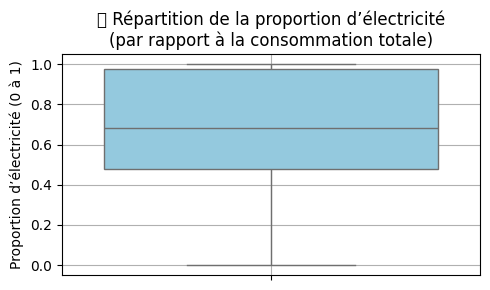

In [13]:

# 📂 Chargement des données nettoyées
df = pd.read_csv("data/2016_Building_Energy_Benchmarking_Purge.csv")

# 🔍 Recherche des colonnes d’électricité
electricity_cols = [col for col in df.columns if 'Electricity' in col and 'kBtu' in col]
total_energy_col = 'SiteEnergyUse(kBtu)'

# ✅ Création de la somme totale de consommation électrique (certaines colonnes sont divisées par usage)
df['Electricity_Use_Total'] = df[electricity_cols].sum(axis=1, skipna=True)

# ⚙️ Calcul du ratio de proportion d’électricité
df['Electricity_Proportion'] = df['Electricity_Use_Total'] / df[total_energy_col]

# 🔁 Nettoyage : garder les cas valides (entre 0 et 1)
df_valid_ratio = df[df['Electricity_Proportion'].between(0, 1)]

# 📊 Statistiques descriptives sur la proportion d’électricité
print(df_valid_ratio['Electricity_Proportion'].describe(percentiles=[.25, .5, .75, .9, .95]))

# 📦 Boxplot
plt.figure(figsize=(5, 3))
sns.boxplot(y=df_valid_ratio['Electricity_Proportion'], color='skyblue')
plt.title("📦 Répartition de la proportion d’électricité\n(par rapport à la consommation totale)")
plt.ylabel("Proportion d’électricité (0 à 1)")
plt.grid(True)
plt.tight_layout()
plt.show()


## ⚡ Poids réel de l’électricité dans la consommation énergétique des bâtiments

### 🎯 Objectif
Quantifier **dans quelle mesure l’électricité contribue à la consommation totale d’énergie** (`SiteEnergyUse(kBtu)`),  
et valider si un modèle basé sur la consommation totale peut capturer l’essentiel des **émissions de gaz à effet de serre**.

---

### 🔍 Méthode
- Extraction des colonnes de consommation électrique (kBtu).
- Somme des valeurs électriques → `Electricity_Use_Total`
- Calcul du ratio :
$
text{Electricity Proportion} = \frac{\text{Electricity\_Use\_Total}}{\text{SiteEnergyUse(kBtu)}}
$

---

### 📊 Résultats statistiques (sur 1578 bâtiments valides)

| Statistique       | Valeur           |
|-------------------|------------------|
| Moyenne           | **68.3 %**        |
| Médiane (50%)     | **68.0 %**        |
| 25e percentile     | 47.7 %           |
| 75e percentile     | 97.5 %           |
| 90e - 95e percentile | **100 %**       |
| Minimum            | 0 %              |
| Maximum            | 100 %            |

---

### 🧠 Interprétation
- Pour **la majorité des bâtiments**, l’électricité constitue la **source principale** d’énergie.
- Pour **plus de 10 % d’entre eux**, elle est **la seule source utilisée**.
- Cela **justifie pleinement** que la consommation totale soit fortement corrélée aux émissions de CO₂,  
puisque l’électricité est **la plus émettrice de CO₂ par kBtu** dans le contexte américain.

---

### ⚠️ Précautions d’usage
- Certains bâtiments combinent gaz, vapeur, fioul… L'effet de levier de l’électricité peut y être atténué.
- Lorsqu'il s'agira modéliser les émissions de CO₂ avec plus de précision, il faudra peut-être:
  - inclure la variable de consommation totale
  - ajouter des indicateurs binaires de source d’énergie
  - intégrer la proportion d’électricité comme feature explicite


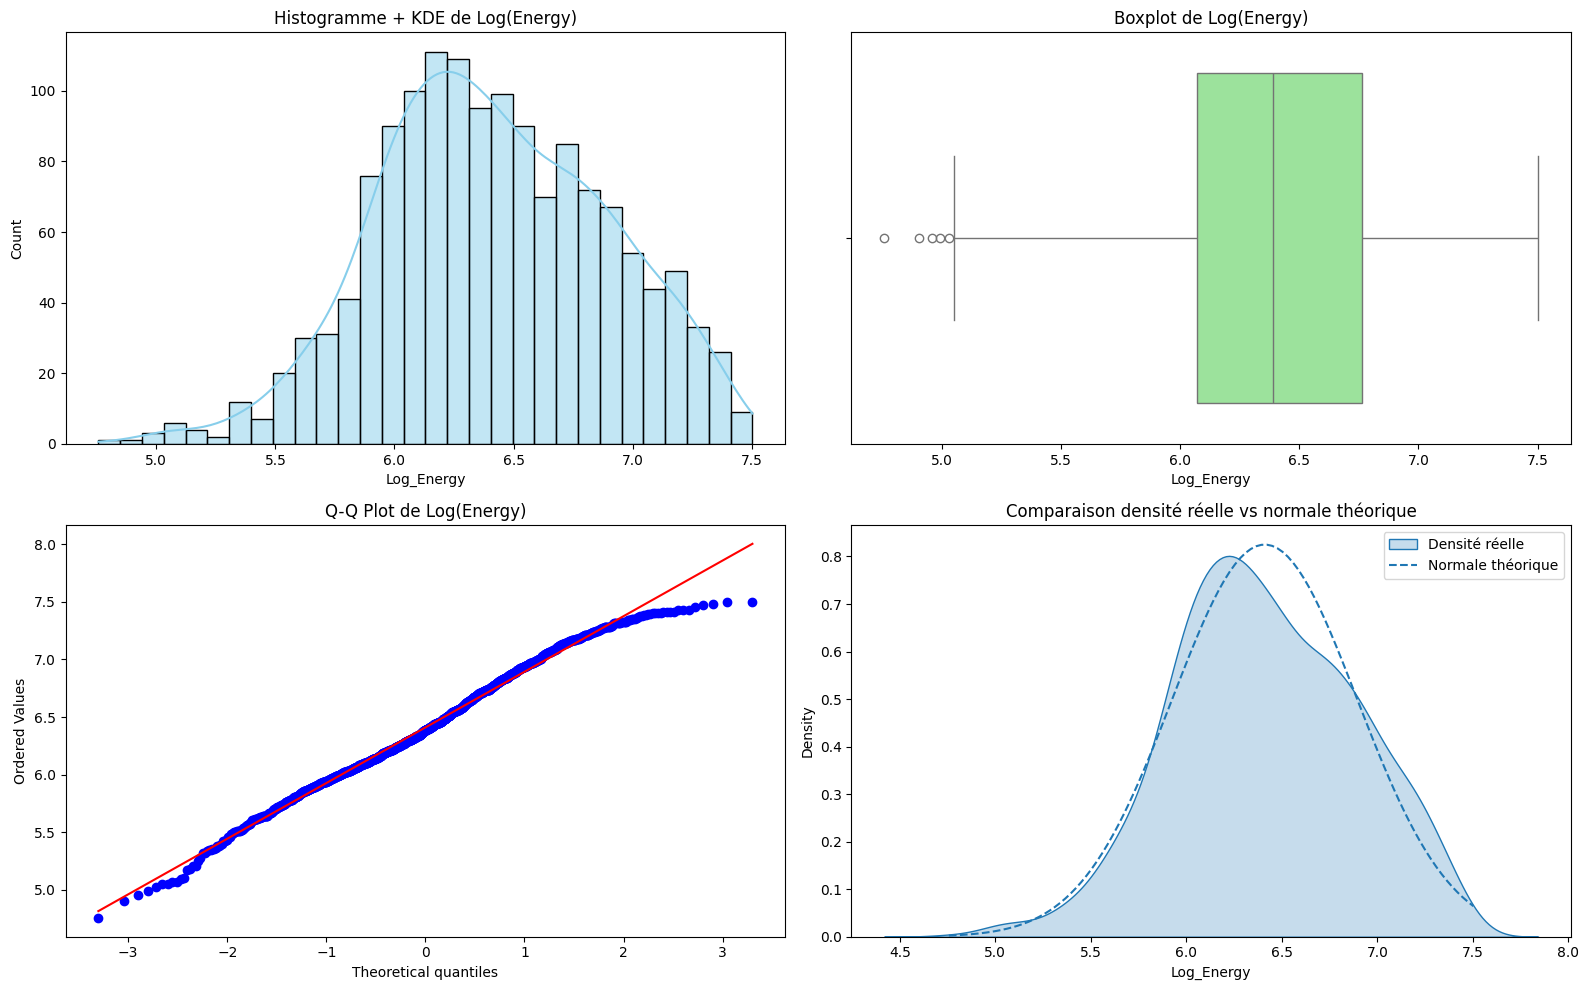

In [14]:
# repartons du bon pied ..
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")

assert 'SiteEnergyUse(kBtu)' in df.columns, "Colonne manquante"

# On garde la variable d'intérêt et on filtre les valeurs manquantes ou nulles
df = df[['SiteEnergyUse(kBtu)']].dropna()
df = df[df['SiteEnergyUse(kBtu)'] > 0]

# Transformation logarithmique pour atténuer les valeurs extrêmes
df['Log_Energy'] = np.log10(df['SiteEnergyUse(kBtu)'])

# Créer une figure avec plusieurs visualisations
plt.figure(figsize=(16, 10))

# 1. Histogramme + courbe KDE
plt.subplot(2, 2, 1)
sns.histplot(df['Log_Energy'], kde=True, bins=30, color='skyblue')
plt.title("Histogramme + KDE de Log(Energy)")

# 2. Boîte à moustaches (boxplot)
plt.subplot(2, 2, 2)
sns.boxplot(x=df['Log_Energy'], color='lightgreen')
plt.title("Boxplot de Log(Energy)")

# 3. Q-Q plot (quantile-quantile plot) pour tester la normalité
plt.subplot(2, 2, 3)
stats.probplot(df['Log_Energy'], dist="norm", plot=plt)
plt.title("Q-Q Plot de Log(Energy)")

# 4. Densité empirique comparée à la courbe normale
plt.subplot(2, 2, 4)
sns.kdeplot(df['Log_Energy'], label='Densité réelle', fill=True)
mean = df['Log_Energy'].mean()
std = df['Log_Energy'].std()
x = np.linspace(df['Log_Energy'].min(), df['Log_Energy'].max(), 100)
plt.plot(x, stats.norm.pdf(x, mean, std), label='Normale théorique', linestyle='--')
plt.title("Comparaison densité réelle vs normale théorique")
plt.legend()

plt.tight_layout()
plt.show()

## 🔎 Analyse statistique de la variable log-transformée `Log_Energy`

---

### 🧠 Objectif

Analyser la distribution de `Log_Energy` (transformation logarithmique de `SiteEnergyUse(kBtu)`) pour évaluer :

- Sa **normalité statistique**
- L' **importance des ouliers**
- Son **utilisabilité dans des modèles linéaires**

---

### 📊 1. **Histogramme + KDE (coin haut gauche)**

#### 📌 Abscisse : `Log_Energy` (valeurs transformées en base 10)
#### 📌 Ordonnée : nombre d’occurrences (fréquence)

**Ce qu'on observe :**

- Une **distribution en cloche** centrée autour de 6.5
- Une **courbe KDE (Kernel Density Estimation)** qui lisse la distribution et suggère une forme proche d'une gaussienne
- Une **légère queue à droite** (asymétrie positive)

#### 🧠 Termes techniques :
- **Unimodale** : une seule "bosse", donc pas de segmentation cachée
- **KDE** : une estimation continue de la densité de probabilité, plus lisible qu’un histogramme brut
- **Asymétrie (Skewness)** : ici, la queue à droite indique que quelques bâtiments ont une consommation très élevée

---

### 📦 2. **Boxplot (coin haut droit)**

**Ce qu'on observe :**

- Le corps du boxplot contient la **plupart des bâtiments**
- Quelques **valeurs extrêmes à droite** sont signalées par des cercles

#### 🧠 Termes techniques :
- **Boîte = 50 % central** (entre 1er et 3e quartile)
- **Moustaches = étendue normale** (±1.5×IQR)
- **Outliers** = points au-delà des moustaches (extrêmes)

---

### 📈 3. **Q-Q Plot (coin bas gauche)**

#### 📌 Abscisse : quantiles théoriques d’une loi normale
#### 📌 Ordonnée : quantiles observés dans `Log_Energy`

**Ce qu'on observe :**

- Les points **suivent bien la diagonale**, sauf aux extrémités
- Un **écart en haut à droite** → quelques très grosses consommations

#### 🧠 Termes techniques :
- **Quantiles** : coupures régulières dans la distribution (10 %, 20 %, etc.)
- **Loi normale théorique** : ce que donnerait une variable parfaitement gaussienne
- **Alignement** = distribution normale ; **écarts** = asymétrie ou outliers

---

### 🌊 4. **Densité réelle vs Normale (coin bas droit)**

#### 📌 Abscisse : `Log_Energy`
#### 📌 Ordonnée : densité de probabilité (surface sous la courbe = 1)

**Ce qu'on observe :**

- La **courbe bleue pleine** (densité réelle) suit la **courbe pointillée** (normale) de très près
- Le **pic est légèrement plus haut** et les **extrémités plus étirées** que la normale

#### 🧠 Termes techniques :
- **Densité** : probabilité relative de voir une valeur dans une plage donnée
- **Kurtosis** : mesure de l’"aplatissement" ou de la "queue épaisse"
- Ici : distribution légèrement **leptokurtique** (queues plus épaisses que la normale)

---

### ✅ Conclusion finale

- La transformation logarithmique a **efficacement réduit la variance**, ce qui rend `Log_Energy` :
  - Plus **symétrique**
  - Moins influencée par les valeurs extrêmes
  - **Compatible avec les hypothèses de normalité** (utile pour les modèles linéaires)
- Il reste quelques outliers, mais **contrôlés**, et surtout **interprétables** (très grands bâtiments énergivores)




## 🔍 Relation surface/consommation definitive

Dans cette visualisation :

* La **consommation énergétique totale (kBtu)** a été transformée en **échelle logarithmique** (`Log_Energy`), tout comme la surface utile (`Log_Surface`).
* Les **valeurs extrêmes** (outliers) ont été identifiées via la méthode IQR (1.5 × IQR au-dessus ou en-dessous des quartiles) puis **exclues** du graphique.

### 🎯 Objectifs de cette visualisation :

* Mettre en évidence la tendance **générale** entre la taille d’un bâtiment et sa consommation, **sans être perturbé par des cas extrêmes**.
* Faciliter l’identification d’une **relation linéaire potentielle** sur les données "propres".



✅ Données chargées : (1441, 20)


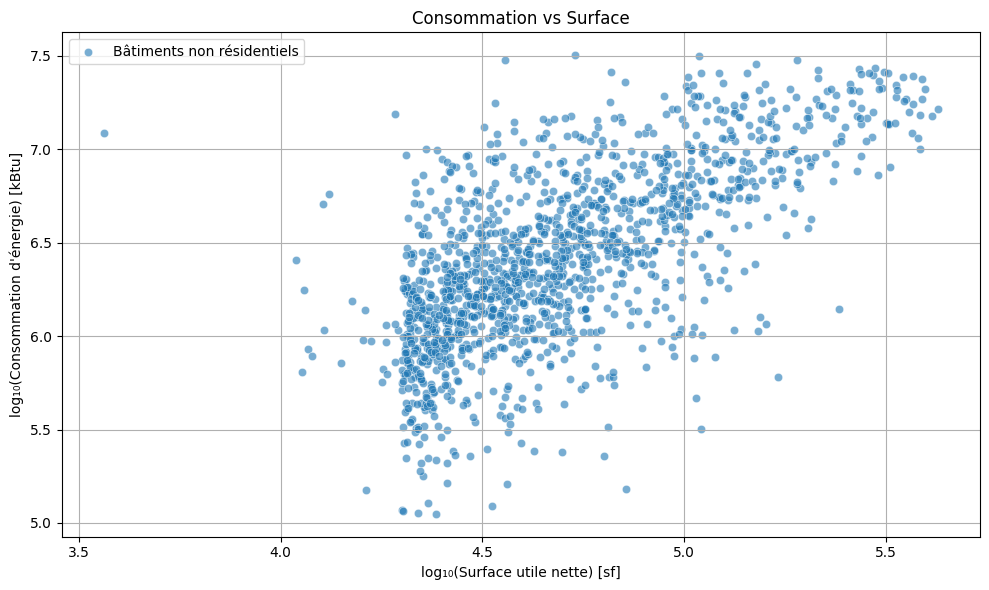

In [15]:

# 🔹 Étape 1 : Charger les données nettoyées
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")
print("✅ Données chargées :", df.shape)

# 🔹 Étape 2 : Log-transformations
df['Log_Surface'] = np.log10(df['PropertyGFABuilding(s)'] + 1)
df['Log_Energy'] = np.log10(df['SiteEnergyUse(kBtu)'] + 1)

# 🔹 Étape 3 : Calcul des bornes IQR
Q1 = df['Log_Energy'].quantile(0.25)
Q3 = df['Log_Energy'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 🔹 Étape 4 : Filtrer les bâtiments normaux (hors outliers)
df_normal = df[(df['Log_Energy'] >= lower_bound) & (df['Log_Energy'] <= upper_bound)]

# 🔹 Étape 5 : Visualisation des bâtiments non résicentiels uniquement
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_normal, x='Log_Surface', y='Log_Energy', alpha=0.6, label="Bâtiments non résidentiels")
plt.xlabel("log₁₀(Surface utile nette) [sf]")
plt.ylabel("log₁₀(Consommation d'énergie) [kBtu]")
plt.title("Consommation vs Surface")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




## 🔍 Étude exploratoire : influence de variables structurelles sur l’énergie

### 🎯 Objectif

Explorer les relations entre la consommation énergétique (`SiteEnergyUse(kBtu)` – en log), et trois variables structurantes :

1. `NumberofFloors` – nombre d’étages
2. `PropertyGFAParking` – présence d’un parking
3. `LargestPropertyUseType` – usage principal du bâtiment

---

### 📊 1. Nombre d’étages

Le **boxplot par groupes d’étages** montre une certaine tendance :

* Les bâtiments **très bas (≤3 étages)** présentent une **dispersion importante** de la consommation.
* La **consommation médiane augmente légèrement** avec le nombre d’étages, mais sans saut brutal.
* Pour les bâtiments de plus de 10 étages, la distribution devient plus homogène, probablement car il s’agit de typologies spécifiques (tours, hôtels, bureaux).

👉 **Interprétation** :
Le nombre d’étages peut jouer un rôle modéré, mais il est surtout **corrélé à la taille globale du bâtiment** (et donc à la consommation brute).

---

### 🚗 2. Présence de parking

Les bâtiments avec un **parking déclaré** ont une **médiane de consommation significativement plus élevée**.
Cela suggère que :

* Les bâtiments avec parking sont souvent **plus grands, plus fréquentés**, ou avec des usages plus énergivores (ex. centres commerciaux, bureaux…).
* Le **parking** peut aussi être le **symbole d’une activité fonctionnelle plus intense**.

👉 **Interprétation** :
La **présence de parking est un bon proxy de "complexité fonctionnelle"** du bâtiment, expliquant une hausse possible de la consommation.

---

### 🏢 3. Type principal de bâtiment (`LargestPropertyUseType`)

Le **type d’usage principal** a un impact **très fort** sur la consommation :

* Les **hôtels**, **hôpitaux**, **laboratoires**, ou **data centers** affichent des consommations nettement plus élevées que des écoles ou des immeubles résidentiels.
* Il y a également une **grande variabilité intra-catégorie**, ce qui justifie un **encodage fin ou un regroupement judicieux** en machine learning.

👉 **Interprétation** :
Le type d’usage est **une des variables explicatives les plus puissantes** de la consommation énergétique. Elle doit impérativement être intégrée dans toute modélisation.

---

## 🧠 Conclusion

Cette analyse exploratoire confirme que certaines variables structurelles simples comme **le nombre d’étages**, la **présence de parking**, et surtout **le type d’usage principal** ont une **influence significative sur la consommation énergétique**.

Elles doivent être soigneusement préparées et transformées avant toute modélisation prédictive.


C:\Users\karap\AppData\Local\Temp\ipykernel_4584\2982637072.py:29: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


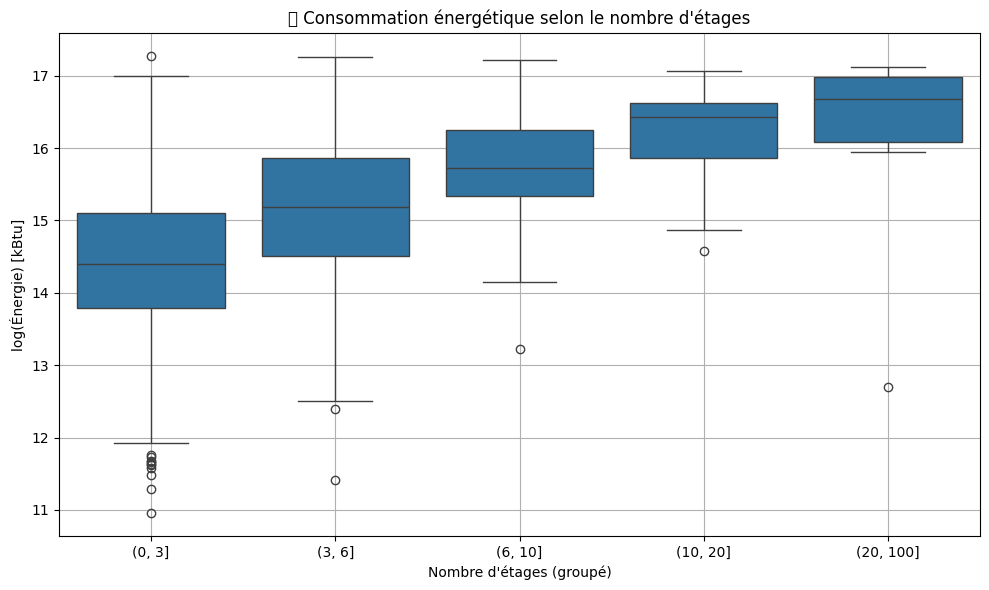

C:\Users\karap\AppData\Local\Temp\ipykernel_4584\2982637072.py:40: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


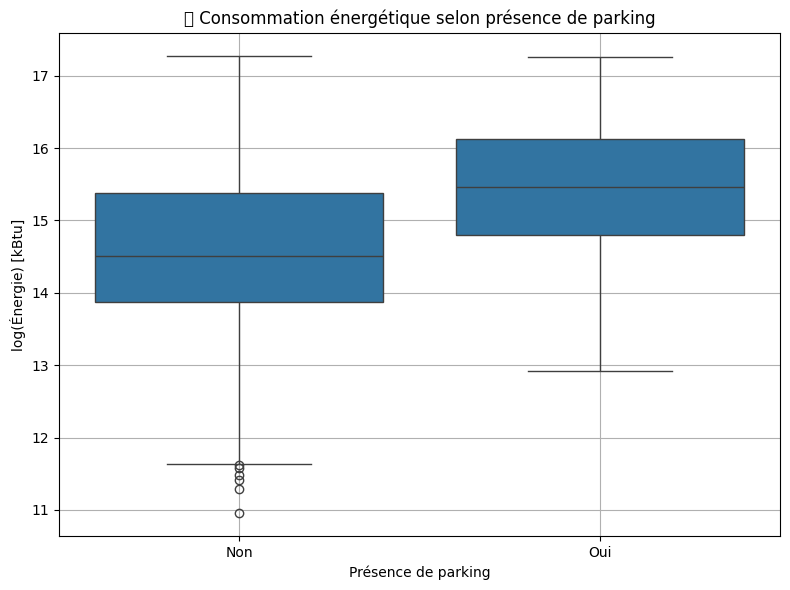

C:\Users\karap\AppData\Local\Temp\ipykernel_4584\2982637072.py:52: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


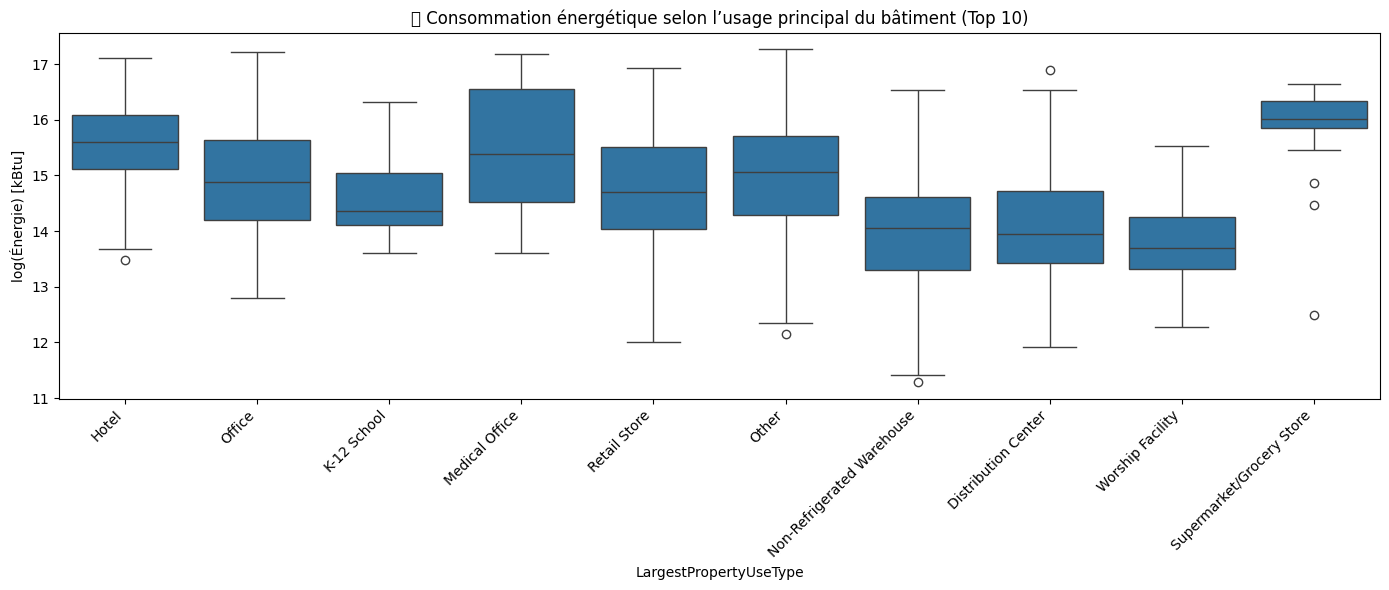

C:\Users\karap\OpenClassRooms\dataprojet6\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


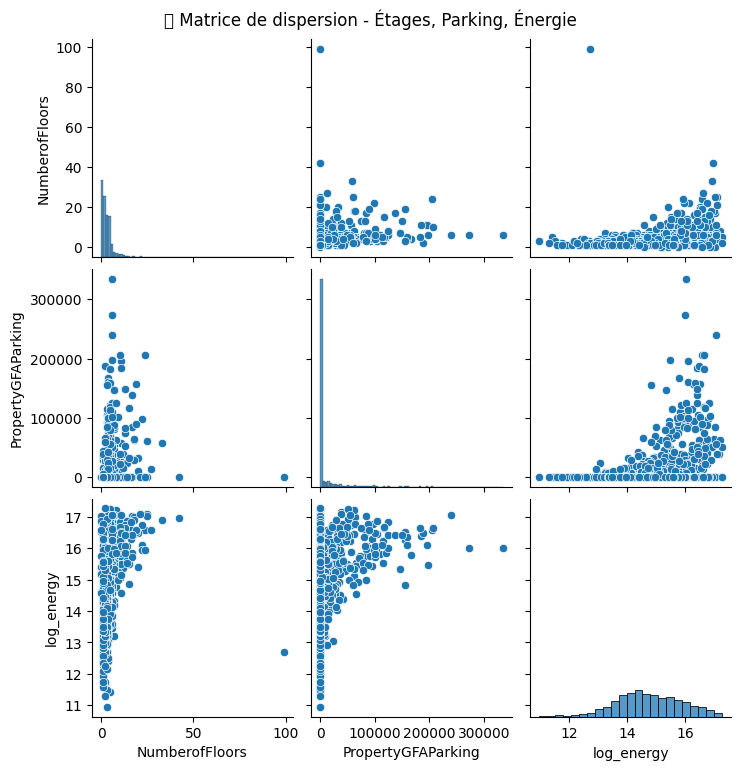

In [16]:

# 📂 Chargement des données
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")

# 🔍 Filtrage des données utiles
df = df[[
    "SiteEnergyUse(kBtu)",
    "NumberofFloors",
    "PropertyGFAParking",
    "LargestPropertyUseType"
]].copy()

# 🧹 Nettoyage : suppression des valeurs manquantes et nulles
df = df.dropna()
df = df[df["SiteEnergyUse(kBtu)"] > 0]

# 🔧 Création d'une variable binaire : présence de parking
df["HasParking"] = df["PropertyGFAParking"] > 0

# 🔄 Transformation log pour lisibilité énergétique
df["log_energy"] = np.log1p(df["SiteEnergyUse(kBtu)"])

# 📊 Boxplot - Influence du nombre d'étages
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.cut(df["NumberofFloors"], bins=[0, 3, 6, 10, 20, 100]), y="log_energy", data=df)
plt.title("🏢 Consommation énergétique selon le nombre d'étages")
plt.xlabel("Nombre d'étages (groupé)")
plt.ylabel("log(Énergie) [kBtu]")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Boxplot - Présence de parking
plt.figure(figsize=(8, 6))
sns.boxplot(x="HasParking", y="log_energy", data=df)
plt.title("🚗 Consommation énergétique selon présence de parking")
plt.xlabel("Présence de parking")
plt.ylabel("log(Énergie) [kBtu]")
plt.xticks([0, 1], ["Non", "Oui"])
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Boxplot - Type d’usage principal
top_types = df["LargestPropertyUseType"].value_counts().nlargest(10).index
df_top = df[df["LargestPropertyUseType"].isin(top_types)]

plt.figure(figsize=(14, 6))
sns.boxplot(x="LargestPropertyUseType", y="log_energy", data=df_top)
plt.title("🏭 Consommation énergétique selon l’usage principal du bâtiment (Top 10)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("log(Énergie) [kBtu]")
plt.tight_layout()
plt.show()

# 📈 Pairplot entre les variables quantitatives
sns.pairplot(df[["NumberofFloors", "PropertyGFAParking", "log_energy"]])
plt.suptitle("📈 Matrice de dispersion - Étages, Parking, Énergie", y=1.02)
plt.show()




## 🏗️ Feature Engineering – Construction des variables explicatives

L’objectif ici est de créer des variables dérivées pertinentes pour améliorer la performance des modèles de prédiction de la consommation énergétique (`SiteEnergyUse(kBtu)`).

---

### 🔹 1. `BuildingAge` – Âge du bâtiment

```python
df['BuildingAge'] = 2025 - df['YearBuilt']
df['BuildingAge'] = df['BuildingAge'].clip(lower=0)
```

* Permet de capter l’effet de l’ancienneté du bâtiment sur sa consommation énergétique.
* Un bâtiment plus ancien est potentiellement moins bien isolé ou moins performant énergétiquement.

---

### 🔹 2. `log_surface` – Surface utile en échelle logarithmique

```python
df['log_surface'] = np.log1p(df['PropertyGFABuilding(s)'])
```

* La transformation logarithmique réduit l’influence des valeurs extrêmes.
* Elle reflète mieux la relation non linéaire entre taille et consommation.

---

### 🔹 3. `surface_per_floor` – Surface moyenne par étage

```python
df['surface_per_floor'] = np.where(
    df['NumberofFloors'] > 0,
    df['PropertyGFABuilding(s)'] / df['NumberofFloors'],
    np.nan
)
```

* Cette variable compense la **corrélation forte attendue** entre `NumberofFloors` et la surface globale.
* Elle capture l’**intensité verticale ou horizontale** du bâtiment : un bâtiment très étalé ou très compact n’a pas les mêmes besoins énergétiques.

---

### 🔹 4. `has_parking` – Présence d’un parking

```python
df['has_parking'] = (df['PropertyGFAParking'] > 0).astype(int)
```

* Variable binaire (0 ou 1).
* Permet de différencier les bâtiments avec une surface dédiée au parking, ce qui peut influencer la consommation (ventilation, éclairage...).

---

### 🔹 5. `UseTypeGrouped_*` – Type principal d’usage du bâtiment (regroupé)

```python
rare_types = type_counts[type_counts < 30].index
df['UseTypeGrouped'] = df['LargestPropertyUseType'].replace(rare_types, 'Other')
df = pd.get_dummies(df, columns=['UseTypeGrouped'], prefix='Use', drop_first=True)
```

* La variable `LargestPropertyUseType` contient de nombreuses modalités (bureaux, écoles, etc.).
* Les types trop rares sont regroupés sous l’étiquette `Other` pour éviter un surapprentissage.
* Le **One-Hot Encoding** est ensuite appliqué pour rendre la variable exploitable par des modèles supervisés.

---

### ✅ Résultat final : les variables prêtes à être injectées dans un modèle

```python
features_to_use = [
    'BuildingAge',
    'log_surface',
    'surface_per_floor',
    'has_parking'
] + [col for col in df.columns if col.startswith('Use_')]



In [19]:
import pandas as pd
import numpy as np

# Chargement
df = pd.read_csv("data/cleaned_2016_Building_Energy_Benchmarking_ML.csv")

# 🔧 1. Âge du bâtiment
df['BuildingAge'] = 2025 - df['YearBuilt']
df['BuildingAge'] = df['BuildingAge'].clip(lower=0)

# 🔧 2. Log de la surface utile
df['log_surface'] = np.log1p(df['PropertyGFABuilding(s)'])

# 🔧 3. Surface par étage
df['surface_per_floor'] = np.where(
    (df['NumberofFloors'] > 0),
    df['PropertyGFABuilding(s)'] / df['NumberofFloors'],
    np.nan
)

# 🔧 4. Présence de parking (1 si PropertyGFAParking > 0)
df['has_parking'] = (df['PropertyGFAParking'] > 0).astype(int)

# 🔧 5. Traitement du type d’usage principal (LargestPropertyUseType)
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna("Unknown")
type_counts = df['LargestPropertyUseType'].value_counts()
rare_types = type_counts[type_counts < 30].index  # seuil modifiable
df['UseTypeGrouped'] = df['LargestPropertyUseType'].replace(rare_types, 'Other')

# One-hot encoding
df = pd.get_dummies(df, columns=['UseTypeGrouped'], prefix='Use', drop_first=True)

# ✅ Définition finale des features à utiliser
features_to_use = [
    'BuildingAge',
    'log_surface',
    'surface_per_floor',
    'has_parking'
] + [col for col in df.columns if col.startswith('Use_')]

# Exemple : X = df[features_to_use]




### ✅ Pourquoi *convertir en dummies* ?

**"Convertir une variable en dummies"** signifie **transformer une variable catégorielle** (texte ou étiquette) en plusieurs **colonnes binaires (0 ou 1)** que les algorithmes de machine learning peuvent comprendre.

---

### 🔄 Exemple simple

Prenons une variable `PropertyTypeGrouped` avec 3 catégories :

| PropertyTypeGrouped |
| ------------------- |
| Office              |
| Hotel               |
| Warehouse           |

Après conversion en *dummies*, on obtient :

| Usage_Hotel | Usage_Office | Usage_Warehouse |
| ----------- | ------------ | --------------- |
| 0           | 1            | 0               |
| 1           | 0            | 0               |
| 0           | 0            | 1               |

Chaque ligne a **un seul 1**, indiquant **le type de bâtiment**.
Le reste vaut 0 car ce n’est **pas ce type-là**.

---

### 🤖 Pourquoi on fait ça ?

* Les **algorithmes de ML** (régression linéaire, arbres, SVM, etc.) **ne comprennent pas le texte**.
* Ils **ne doivent pas interpréter** une catégorie comme **un ordre numérique** (ex: Office=1, Hotel=2… serait faux !)
* Les *dummies* permettent de dire **"est-ce que c’est ce type ou pas"**, **sans biais numérique**.

---

### 🧠 Astuce : `drop_first=True`

Dans `pd.get_dummies(..., drop_first=True)`, on supprime **une colonne** pour éviter la **multicolinéarité** (dans un modèle linéaire, sinon les colonnes sont linéairement dépendantes).
Cela ne change rien à l’information, car on peut la **reconstruire par différence**.


